# Graphics Classifier

Source:
+ Chart_Synthetic : Synthetic dataset of graphic images
+ Chart2020       : Dataset for infographics 2020
+ clef16          : Clef challenge 2016
+ clef13          : Clef challenge 2013


### 1. Importing Libraries

In [2]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [4]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/graphics_dataset_final.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH 

My base path is /mnt
The given dataset is located here: ../data/graphics_dataset_final.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [5]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Graphics'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Graphics to save our sweep iterations


In [6]:
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier only with the class "GRAPHICS"

In [7]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_graphics,dict_label = label_encoder_target(df,target_col='modality')
df.head()

,img,original,modality,source,img_path,higher_modality,split_set
0,100050.png,Scatter,scatterplot,Chart_Synthetic,chart_synthetic_1/train/100050.png,GRAPHICS,TRAIN
1,0.png,Grouped horizontal bar,histogram,Chart_Synthetic,chart_synthetic_1/train/0.png,GRAPHICS,TRAIN
2,100051.png,Scatter,scatterplot,Chart_Synthetic,chart_synthetic_1/train/100051.png,GRAPHICS,TRAIN
3,1.png,Grouped horizontal bar,histogram,Chart_Synthetic,chart_synthetic_1/train/1.png,GRAPHICS,VAL
4,100052.png,Scatter,scatterplot,Chart_Synthetic,chart_synthetic_1/train/100052.png,GRAPHICS,TRAIN


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


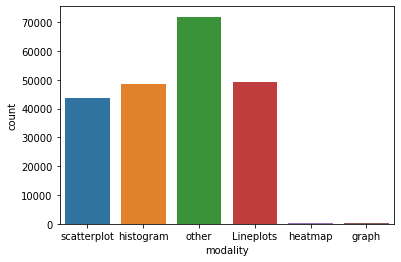

In [7]:
sns.countplot(df['modality'])
plt.show()

In [8]:
dict_label

{'Lineplots': 0,
 'graph': 1,
 'heatmap': 2,
 'histogram': 3,
 'other': 4,
 'scatterplot': 5}

In [9]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_graphics,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=72)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.9257, 0.9211, 0.9220])
Std :  tensor([0.2065, 0.1992, 0.2115])


### 4. Sweep Running
+ First We will define the image transformations that we are goint to use for the training , evaluation and test

In [10]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [11]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Graphics
Metric Monitor: val_avg_loss


### 4.1 ResnetClassifier


In [17]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [0.00001]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet18"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [32]
            
        }
      
    }
}

In [18]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: g6r4tbep
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Graphics/sweeps/g6r4tbep


In [19]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [20]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_graphics,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer,dm
    torch.cuda.empty_cache() 
    wandb.finish()

wandb: Agent Starting Run: jvjpnzqh with config:
wandb: 	batch_size: 32
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet18
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: golden-sweep-1
Num_Classes 6


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch    12: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 99.50886535644531
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9905
         1.0       0.88      1.00      0.94        29
         2.0       0.82      1.00      0.90        27
         3.0       1.00      1.00      1.00      9737
         4.0       1.00      1.00      1.00     14350
         5.0       0.99      0.99      0.99      8710

    accuracy                           1.00     42758
   macro avg       0.95      1.00      0.97     42758
weighted avg       1.00      1.00      1.00     42758


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9965631144347548,
 'Macro F1-Score': 0.9691589835662674,
 'test_acc': tensor(99.5089, device='cuda:0'),
 'test_loss': tensor(0.0170, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,138969
_runtime,5737
_timestamp,1612994344
val_acc,99.50887
val_avg_loss,0.01703
epoch,12
train_acc,99.9275
train_avg_loss,0.0024
test_acc,99.50887
test_loss,0.01703


lr-Adam,████████████▁
_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄█
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
val_acc,▁▅▆▆▆▇▇█▇▇▇▆█
val_avg_loss,█▃▂▂▂▁▁▁▁▂▂▃▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇██
train_acc,▁▅▆▆▇▇▇▇▇████
train_avg_loss,█▃▂▂▂▂▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


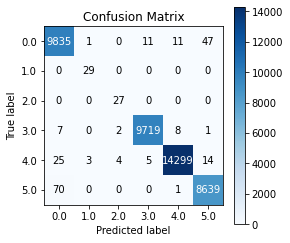

In [21]:
wandb.agent(sweep_id, function=sweep_iteration);

## 5.Testing